In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from numba import jit, njit
import numba
import math
import numpy as np
import cv2
import scipy.signal
import scipy.ndimage
import progressbar
import os
import sys
sys.path.append("../../")
import helpers

# 3D Reconstruction
This week we will look at generating a virtual representation from a set of (real world) images. Given a collection of images from different angles the aim is to create a 3D reconstruction of the scene that the images capture. Common use cases include augmented reality, [virtual cameras](https://www.youtube.com/watch?v=J7xIBoPr83A) and [photogrammetry](https://www.youtube.com/watch?v=wnt64H-Wouk).

## Pipeline
Estimating the camera matrix is the first step of 3D reconstruction. As you learned in the previous notebook we can guess the camera matrix if we have a set of known pixels/3D point pairs. If we have two images of the same object then it is also possible to compute the camera matrices of each of the images by finding matching pixels. Two pixels match if they both see the same point (in 3D). We usually find these points by matching easily recognizable parts of the image such as corners, which we can find with a corner detection algorithm as discussed in the first notebook.

### Setup
For all the following assignments we will use the data set that is made publicly available by [École polytechnique fédérale de Lausanne](https://www.epfl.ch/labs/cvlab/data/data-strechamvs/). This data set already includes the camera matrices as well as a set the set of 3D points that were generated from matching pixel pairs. The following code loads the 2 input image, their camera matrices and the 3D points

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
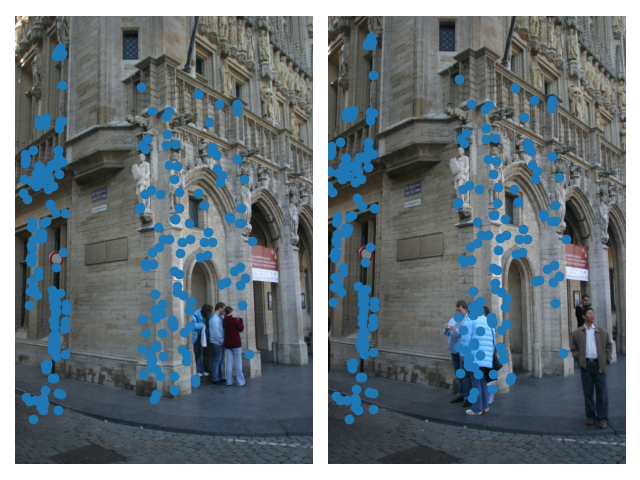

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
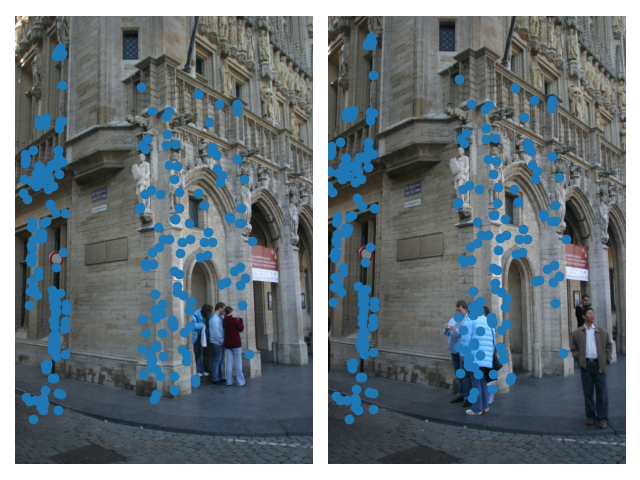

In [2]:
# File with helper functions specific to this notebook
import mvs

# Alternative data set 1
if False:
    flip_axis = False
    dataset_source = "epfl"
    load_point_kwargs = {}
    image0_file = os.path.join(helpers.dataset_folder, "week4", "3d reconstruction", "face", "camera1", "001", "image_0000.pnm.ppm")
    image1_file = os.path.join(helpers.dataset_folder, "week4", "3d reconstruction", "face", "camera2", "001", "image_0000.pnm.ppm")
    camera0_file = os.path.join(helpers.dataset_folder, "week4", "3d reconstruction", "face", "camera1", "camera.txt")
    camera1_file = os.path.join(helpers.dataset_folder, "week4", "3d reconstruction", "face", "camera2", "camera.txt")
    points0_file = os.path.join(helpers.dataset_folder, "week4", "3d reconstruction", "face", "camera1", "001", "image_0000.pnm.ppm.featureCoord")
    points1_file = os.path.join(helpers.dataset_folder, "week4", "3d reconstruction", "face", "camera2", "001", "image_0000.pnm.ppm.featureCoord")

if True:
    flip_axis = True
    dataset_source = "epfl"
    load_point_kwargs = {}
    image0_file = os.path.join(helpers.dataset_folder, "week4", "3d reconstruction", "brussel", "rdimage.000.ppm")
    image1_file = os.path.join(helpers.dataset_folder, "week4", "3d reconstruction", "brussel", "rdimage.001.ppm")
    points0_file = f"{image0_file}.3Dpoints"
    points1_file = f"{image1_file}.3Dpoints"
    camera0_file = f"{image0_file}.camera"
    camera1_file = f"{image1_file}.camera"
    min_dist = 5
    max_dist = 50

# Alternative data set 2
if False:
    flip_axis = False
    dataset_source = "embree"
    load_point_kwargs = { "relative_number_of_points": 0.005 }
    image0_file = os.path.join(helpers.dataset_folder, "week4", "3d reconstruction", "sponza", "color", "cam1.png")
    image1_file = os.path.join(helpers.dataset_folder, "week4", "3d reconstruction", "sponza", "color", "cam2.png")
    camera0_file = os.path.join(helpers.dataset_folder, "week4", "3d reconstruction", "sponza", "cameras", "cam1.txt")
    camera1_file = os.path.join(helpers.dataset_folder, "week4", "3d reconstruction", "sponza", "cameras", "cam2.txt")
    points0_file = os.path.join(helpers.dataset_folder, "week4", "3d reconstruction", "sponza", "world_pos", "cam1.npy")
    points1_file = os.path.join(helpers.dataset_folder, "week4", "3d reconstruction", "sponza", "world_pos", "cam2.npy")
    min_dist = 100
    max_dist = 2000

image0 = helpers.imread_normalized_float_grayscale(image0_file)
image1 = helpers.imread_normalized_float_grayscale(image1_file)
if flip_axis:
    image0 = image0.T[::-1,:]
    image1 = image1.T[::-1,:]
image0_half_res = helpers.resize_image(image0, 0.5)
image1_half_res = helpers.resize_image(image1, 0.5)
image0_quarter_res = helpers.resize_image(image0, 0.25)
image1_quarter_res = helpers.resize_image(image1, 0.25)

image0_color = helpers.imread_normalized_float(image0_file)
image1_color = helpers.imread_normalized_float(image1_file)
if flip_axis:
    image0_color = mvs.flip_color_image_axis(image0_color)
    image1_color = mvs.flip_color_image_axis(image1_color)
image0_color_half_res = helpers.resize_image(image0_color, 0.5)
image1_color_half_res = helpers.resize_image(image1_color, 0.5)
image0_color_quarter_res = helpers.resize_image(image0_color, 0.25)
image1_color_quarter_res = helpers.resize_image(image1_color, 0.25)

# NOTE: the camera data is stored as a tuple of (position, intrinsic matrix, extrinsic matrix)
# 3D points may be projected into 2D as follows:
# tmp = (intr * extr) * vec4(point3D, 1)
# pixel = tmp.xy / tmp.z
#
# We have implemented this function for you in mvs.py (see project_points(camera, points3D))
#camera0 = mvs.load_camera_data(camera0_file)
#camera1 = mvs.load_camera_data(camera1_file)
camera0 = mvs.load_camera(camera0_file, dataset_source)
camera1 = mvs.load_camera(camera1_file, dataset_source)
if flip_axis:
    camera0 = mvs.flip_camera_axis(camera0)
    camera1 = mvs.flip_camera_axis(camera1)
camera0_half_res = mvs.scale_camera(camera0, 0.5)
camera1_half_res = mvs.scale_camera(camera1, 0.5)
camera0_quarter_res = mvs.scale_camera(camera0, 0.25)
camera1_quarter_res = mvs.scale_camera(camera1, 0.25)

points3D_0 = mvs.load_points3D(points0_file, dataset_source, **load_point_kwargs)
points3D_1 = mvs.load_points3D(points1_file, dataset_source, **load_point_kwargs)

def plot_image_and_points(ax, image, camera_data, points3D):
    points2D = mvs.project_points(camera_data, points3D)
    ax.axis("off")
    ax.imshow(image)
    # Show up to 250 points so that we can still see the image underneath.
    ax.scatter(points2D[:250,0], points2D[:250,1])
    
fig, (ax0, ax1) = plt.subplots(1, 2)
plot_image_and_points(ax0, image0_color, camera0, points3D_0)
plot_image_and_points(ax1, image1_color, camera1, points3D_0)
fig.tight_layout()
fig.show()

## Plotting the known 3D points
The following code plots the 3D points that were generated when computing the camera matrices. If you move the camera around you should start to recognize the general shape of the building.

In [3]:
# View it.
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode()

def plotly_points(points, size=2, color=None, label="Points"):
    # 3D plot
    if flip_axis:
        x = points[:, 1]
        y = points[:, 2]
        z = points[:, 0]
    else:
        # In graphics z = depth, when plotting z = height
        x = points[:, 0]
        z = points[:, 1]
        y = points[:, 2]
    
    if color is None:
         color = np.random.rand(len(points))
    elif isinstance(color, list) or isinstance(color, np.ndarray):
        color = [f"rgb({255*r},{255*g},{255*b})" for b, g, r in color]
        
    return go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='markers',
        marker=dict(
            size=size,
            color=color, # set color to an array/list of desired values
            colorscale='Viridis', # choose a colorscale
            opacity=1.0
        ),
        name=label
    )
    
def plotly_point(point, **kwargs):
    return plotly_points(np.array([point]), **kwargs)

def plotly_camera(camera, size=8, label="Camera", **kwargs):
    return plotly_point(camera[0], size=size, label=label, **kwargs)

def plotly_frustum(camera, resolution):
    h, w = resolution
    p0 = camera[0]
    _, d0 = mvs.pixel_to_ray(camera, (0, 0))
    _, d1 = mvs.pixel_to_ray(camera, (w, 0))
    _, d2 = mvs.pixel_to_ray(camera, (w, h))
    _, d3 = mvs.pixel_to_ray(camera, (0, h))
    
    dist = 30
    vertices = np.array([p0, p0 + dist*d0, p0 + dist*d1, p0 + dist*d2, p0 + dist*d3])
    indices = np.array([[0, 1, 2], [0, 2, 3], [0, 3, 4], [0, 4, 1]])
    if flip_axis:
        x = vertices[:, 1]
        y = vertices[:, 2]
        z = vertices[:, 0]
    else:
        # In graphics z = depth, when plotting z = height
        x = vertices[:, 0]
        z = vertices[:, 1]
        y = vertices[:, 2]
    return go.Mesh3d(
        x=x,
        y=y,
        z=z,
        i=indices[:,0],
        j=indices[:,1],
        k=indices[:,2],
        facecolor=["red", "green", "blue", "yellow"],
        opacity=0.2
    )
    
def plotly_epipolar_plane(camera0, camera1, points):
    camera0_pos = camera0[0]
    camera1_pos = camera1[0]
    
    dist = 5
    vertices = np.append(np.array([camera0_pos, camera1_pos]), points, axis=0)
    indices = np.array([[0, 1, i+2] for i in range(len(points))])
    if flip_axis:
        x = vertices[:, 1]
        y = vertices[:, 2]
        z = vertices[:, 0]
    else:
        # In graphics z = depth, when plotting z = height
        x = vertices[:, 0]
        z = vertices[:, 1]
        y = vertices[:, 2]
    return go.Mesh3d(
        x=x,
        y=y,
        z=z,
        i=indices[:,0],
        j=indices[:,1],
        k=indices[:,2],
        facecolor=["red"],
        opacity=1.0
    )

# Project points onto image and get color from pixel
points2D_0 = mvs.project_points(camera0, points3D_0)
colors = []
for x, y in points2D_0:
    colors.append(image0_color[helpers.round_to_int(y), helpers.round_to_int(x)])

trace1 = plotly_points(points3D_0, color=colors)
trace2 = plotly_camera(camera0, size=8, color="red", label="Camera 0")
trace3 = plotly_frustum(camera0, image0.shape)
trace4 = plotly_camera(camera1, size=8, color="blue", label="Camera 1")
trace5 = plotly_frustum(camera1, image0.shape)
trace6 = plotly_epipolar_plane(camera0, camera1, points3D_0[:1])
data = [trace1, trace2, trace3, trace4]
layout = go.Layout(margin={"l": 0, "r": 0, "b": 0, "t": 0}, scene={"aspectmode": "cube"})
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='3d-scatter-colorscale')

## Triangulating matching view rays
If we know that two pixels are looking at the same point in 3D then it is possible to compute the position of that 3D point based on the pixel coordinates in both images. Each pixel defines a ray in 3D. A ray is a half open light segment: it starts at the camera and it goes through the pixel towards infinity. Image the two rays corresponding to the matching pixels: one starting from `camera0` and the other at `camera1`. If the rays are defined with infinite precision then they will intersect at the 3D point that is visible at those pixels. Due to measurement and computer arithmetic errors it is very uncommon for two rays to exactly intersect however. So instead we have to look for the closest point between the two rays.

A ray is defined by the following formula: $\vec{p}=\vec{o}+t\vec{d}$. Here, $\vec{o}$ is the starting point and $\vec{d}$ is the direction of the ray. $t$ a ray with a particular length.

Given two rays $\vec{p}=\vec{o_0}+t\vec{d_0}$ and $\vec{q}=\vec{o_1}+s\vec{d_1}$ we want to find the closest point between the two rays.

The closest point lies on the line between the two points $\vec{p}$ and $\vec{q}$ on ray 1 and 2 respectively for which $\lVert pq \rVert$ is minimal. This line $pq=\vec{q} - \vec{p}$ is perpendicular to both rays.

$$
\vec{d_0} \cdot pq = 0 \text{ and } \vec{d_1} \cdot pq = 0 \\
\vec{d_0} \cdot (\vec{o_1} + s\vec{d_1} - \vec{o_0} - t\vec{d_0}) = 0 \text{ and } \vec{d_1} \cdot (\vec{o_1} + s\vec{d_1} - \vec{o_0} - t\vec{d_0}) = 0
$$

$$
\vec{d_0}\cdot\vec{d_1}s - \vec{d_0}\cdot\vec{d_0}t = \vec{o_0}\cdot\vec{d_0} - \vec{o_1}\cdot\vec{d_0} \text{ and } \vec{d_1}\cdot\vec{d_1}s - \vec{d_0}\cdot\vec{d_1}t = \vec{o_0}\cdot\vec{d_1} - \vec{o_1}\cdot\vec{d_1}
$$

Multiply the former by $\vec{d_0}\cdot\vec{d_1}$ and the latter by $\vec{d_0}\cdot\vec{d_0}$:
$$
\vec{d_0}\cdot\vec{d_1}\vec{d_0}\cdot\vec{d_1}s - \vec{d_0}\cdot\vec{d_1}\vec{d_0}\cdot\vec{d_0}t = \vec{d_0}\cdot\vec{d_1}(\vec{o_0}\cdot\vec{d_0} - \vec{o_1}\cdot\vec{d_0}) \text{, and:}\\
\vec{d_0}\cdot\vec{d_0}\vec{d_1}\cdot\vec{d_1}s - \vec{d_0}\cdot\vec{d_1}\vec{d_0}\cdot\vec{d_0}t = \vec{d_0}\cdot\vec{d_0}(\vec{o_0}\cdot\vec{d_1} - \vec{o_1}\cdot\vec{d_1})
$$

By subtracting both equations we can derive $s$:
$$
(\vec{d_0}\cdot\vec{d_1}\vec{d_0}\cdot\vec{d_1} - \vec{d_0}\cdot\vec{d_0}\vec{d_1}\cdot\vec{d_1})s = \vec{d_0}\cdot\vec{d_1}(\vec{o_0}\cdot\vec{d_0} - \vec{o_1}\cdot\vec{d_0}) - \vec{d_0}\cdot\vec{d_0}(\vec{o_0}\cdot\vec{d_1} - \vec{o_1}\cdot\vec{d_1}) \\
s = \frac{\vec{d_0}\cdot\vec{d_1}(\vec{o_0}\cdot\vec{d_0} - \vec{o_1}\cdot\vec{d_0}) - \vec{d_0}\cdot\vec{d_0}(\vec{o_0}\cdot\vec{d_1} - \vec{o_1}\cdot\vec{d_1})} {\vec{d_0}\cdot\vec{d_1}\vec{d_0}\cdot\vec{d_1} - \vec{d_0}\cdot\vec{d_0}\vec{d_1}\cdot\vec{d_1}}
$$

With $s$ known we can now rewrite either one of the earlier equations to compute $t$:
$$
\vec{d_0}\cdot\vec{d_1}s - \vec{d_0}\cdot\vec{d_0}t = \vec{o_0}\cdot\vec{d_0} - \vec{o_1}\cdot\vec{d_0} \\
\vec{d_0}\cdot\vec{d_0}t = \vec{d_0}\cdot\vec{d_1}s - \vec{o_0}\cdot\vec{d_0} + \vec{o_1}\cdot\vec{d_0} \\
t = \frac{\vec{d_0}\cdot\vec{d_1}s - \vec{o_0}\cdot\vec{d_0} + \vec{o_1}\cdot\vec{d_0}} {\vec{d_0}\cdot\vec{d_0}}
$$

### Exercise 8 (2 points)
Implement a function that finds the closest points $p$ and $q$ on both rays as described above.

**NOTE** Because this function will be called many times performance is critical. In this case we cannot efficiently express ourselfs with Python/numpy alone so we will use *Numba* to translate our code into native machine instructions. Numba supports most numpy functions (such as `np.dot`) but can be pedantic regarding implicit data type conversions so please be aware. **Do not remove the `@njit` decorator from your final solution** (you are free to do so while working on the exercise). You can use `np.divide` to divide two numbers without division by zero throwing an error.

In [4]:
# Find the closest points p and q on ray 0 and ray 1
@njit
def closest_points_on_rays(ray0, ray1):
    o0, d0 = ray0
    o1, d1 = ray1

    snom0 = np.dot(d0, d1) * (np.dot(o0, d0) - np.dot(o1, d0))
    snom1 = np.dot(d0, d0) * (np.dot(o0, d1) - np.dot(o1, d1))
    snom = snom0 - snom1
    sdenom = np.dot(d0, d1) * np.dot(d0, d1) - np.dot(d0, d0) * np.dot(d1, d1)
    s = np.divide(snom, sdenom)

    tnom = np.dot(d0, d1) * s - np.dot(o0, d0) + np.dot(o1, d0)
    tdenom = np.dot(d0, d0)
    t = np.divide(tnom, tdenom)
    
    p = o0 + t*d0
    q = o1 + s*d1
    return (p, q)
    
# Find the closest point between both rays (half way between p and q)
@njit
def closest_point_between_rays(ray0, ray1):
    p0, p1 = closest_points_on_rays(ray0, ray1)
    return (p0 + p1) / 2

### Test of exercise 8
To test your solution we will project the set of known 3D points into both images. Then we try to compute the 3D positions of each point by "shooting" a ray through the pixel in both images onto which the 3D point projects. The graph plots the percentage of points who's error is smaller than the value that is indicated on the horizontal axis. The error should never be larger than $0.5$.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
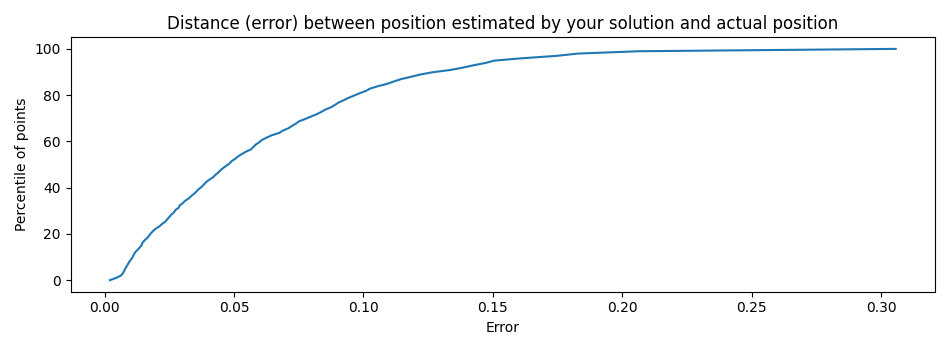

In [5]:
points2D_0 = mvs.project_points(camera0, points3D_0)
points2D_1 = mvs.project_points(camera1, points3D_0)

triangulation_errors = np.empty((len(points3D_0)), np.float32)
for i, point3D_ref in enumerate(points3D_0):
    pixel0 = points2D_0[i,:].astype(int)
    pixel1 = points2D_1[i,:].astype(int)
    
    ray0 = mvs.pixel_to_ray(camera0, pixel0)
    ray1 = mvs.pixel_to_ray(camera1, pixel1)
    
    point3D = closest_point_between_rays(ray0, ray1)
    triangulation_errors[i] = np.linalg.norm(point3D - point3D_ref)

x = np.linspace(0, 100, 100)
y = np.percentile(triangulation_errors, x)
    
fig, ax = plt.subplots(figsize=helpers.default_fig_size)
ax.set_title("Distance (error) between position estimated by your solution and actual position")
ax.set_xlabel("Error")
ax.set_ylabel("Percentile of points")
ax.plot(y, x)
fig.tight_layout()
plt.show()

assert(np.mean(triangulation_errors) < 0.1)
assert(np.max(triangulation_errors) < 0.5)

## Epipolar lines
To create a 3D reconstruction from two images we have to find matching pixel pairs. Comparing each pixel in one image with each pixel in the other image is not only inefficient but might also lead to matches who's rays do not get close to each other. We could enforce this by discarding pixels whos rays do not get near eachother.

The demo below allows you to interactively visualize which pixels from the right image might see a point in the left image (their rays are very close). **Click anywhere on the left image to pick a point**. For each pixel in the right image we "shoot" a ray and if that ray (almost) intersects the ray from the first camera (going through the clicked pixel) then the pixel is marked (assigned a color).

Compiling...
Done


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
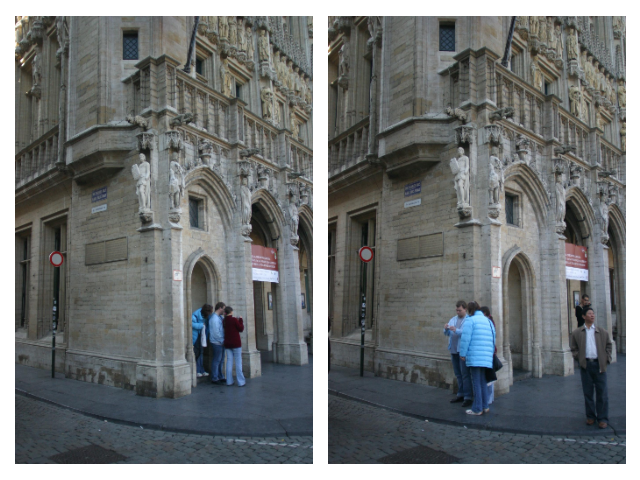

In [6]:
@njit
def draw_epipolar_line(image1, camera0, camera1, pixel0, color):
    out_image = image1.copy()
    
    ray0 = mvs.pixel_to_ray(camera0, pixel0)
    height, width, _ = image1.shape
    for y1 in range(height):
        for x1 in range(width):
            pixel1 = (x1, y1)
            ray1 = mvs.pixel_to_ray(camera1, pixel1)

            p0, p1 = closest_points_on_rays(ray0, ray1)
            p0 = mvs.project_point(camera1, p0)
            p1 = mvs.project_point(camera1, p1)
            if np.linalg.norm(p0 - p1) < 1:
                out_image[y1, x1] = color
    return out_image

def plot_interactive_epipolar_lines(image0, image1, camera0, camera1):
    fig, (ax1, ax2) = plt.subplots(1, 2)

    clicked_points = []
    output_image = image1.copy()
    
    def redraw():
        ax1.clear()
        ax2.clear()
        ax1.axis("off")
        ax2.axis("off")
        ax1.imshow(image0)
        for pixel, color in clicked_points:
            ax1.scatter([pixel[0]], [pixel[1]], c=[color])
        ax2.imshow(output_image)
    
    def onclick(event):
        nonlocal output_image
                
        color = np.random.rand((3)).astype(np.float32)
        pixel = (event.xdata, event.ydata)
        
        clicked_points.append((pixel, color))
        output_image = draw_epipolar_line(output_image, camera0, camera1, pixel, color)
        redraw()
    
    # Call draw_epipolar_line (discarding output) so that it is compiled before the user starts clicking.
    print("Compiling...")
    draw_epipolar_line(output_image, camera0, camera1, (100, 100), np.ones((3), np.float32))
    print("Done")
    
    redraw()
    
    fig.tight_layout()
    fig.canvas.mpl_connect("button_press_event", onclick)
    #fig.show()

#image0 = imread_normalized_float_grayscale(image0_file).T[::-1,:]
#image1 = imread_normalized_float_grayscale(image1_file).T[::-1,:]

plot_interactive_epipolar_lines(image0_color_quarter_res, image1_color_quarter_res, camera0_quarter_res, camera1_quarter_res)
# TODO: (exercise) click on image and draw epipolar line in the other image. 3D view next to it visualizing the 3D points while they are added

As you can see the rays through pixels in the left image create lines in the right image. These lines are called epipolar lines. Intuitively, we are projecting a 3 dimensional line (ray) onto a the camera sensor (which is a plane) which results in a line in 2D. We can take advantage of this knowledge to speed up 3D reconstruction. Instead of comparing every pixel in the left image to every pixel in the right image we only have to compare the pixels along a line.

## Computing epipolar lines more efficiently
We can also compute and draw the epipolar line without having to go over all pixels in the image (which is very slow). The line contains all the pixels (in the right image) that (almost) intersect a ray through a pixel of the left image. So what we can do is compute two arbitrary points along this ray (in 3D) and then project those two points onto the right image. The epipolar line is then simply the *2D* line through those two pixels.

The following code demonstrates how this can be done efficiently. Click on the left image to create a ray. The epipolar line will be draw in the right image including the two (arbitrary) points along the ray which were used to draw the line.

Compiling...
Done


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
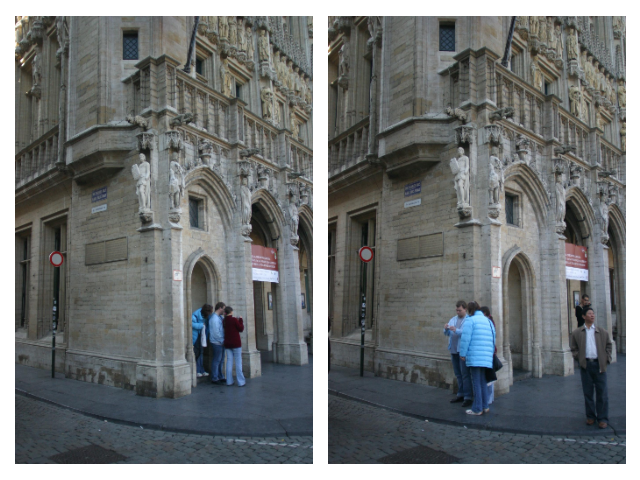

In [7]:
def draw_epipolar_line2(image1, ax2, camera0, camera1, pixel0, color):
    # Create a ray going through pixel0 of camera0
    ray = mvs.pixel_to_ray(camera0, pixel0)
    origin, direction = ray
    
    # Take two arbitrary points on the ray and transform them into the second image
    p0 = mvs.project_point(camera1, origin + 10 * direction)
    p1 = mvs.project_point(camera1, origin + 40 * direction)

    # Draw the two points that we used in the right image
    ax2.scatter([p0[0], p1[0]], [p0[1], p1[1]], c=color.reshape(1,3))
    
    # Draw a line through the points in the right image
    return mvs.draw_line_through_pixels(image1, p0, p1, color)


def plot_interactive_epipolar_lines(image0, image1, camera0, camera1):
    fig, (ax1, ax2) = plt.subplots(1, 2)

    clicked_points = []
    output_image = image1.copy()
    
    def clear():
        ax1.clear()
        ax2.clear()
        ax1.axis("off")
        ax2.axis("off")
    
    def redraw():
        ax1.imshow(image0)
        for pixel, color in clicked_points:
            ax1.scatter([pixel[0]], [pixel[1]], c=color.reshape(1,3))
        ax2.imshow(output_image)
    
    def onclick(event):
        nonlocal output_image
                
        color = np.random.rand((3)).astype(np.float32)
        pixel = (event.xdata, event.ydata)
        
        clicked_points.append((pixel, color))
        clear()
        output_image = draw_epipolar_line2(output_image, ax2, camera0, camera1, pixel, color)
        redraw()
    
    # Call draw_epipolar_line (discarding output) so that it is compiled before the user starts clicking.
    print("Compiling...")
    draw_epipolar_line2(output_image, ax2, camera0, camera1, (100, 100), np.ones(3))
    print("Done")
    
    clear()
    redraw()
    
    fig.tight_layout()
    fig.canvas.mpl_connect("button_press_event", onclick)
    #fig.show()

plot_interactive_epipolar_lines(image0_color_quarter_res, image1_color_quarter_res, camera0_quarter_res, camera1_quarter_res)

## Photo consistency measures
To find which pixels are seeing the same 3D point, we need a way of expressing the similarity between two pixels (in two different images). A single pixel (3 values in RGB) often does not capture enough information to find the correct match out of thousands of potential matches. So we define a support domain, which is a small region around around the pixel of interest (similar to the cutout in the corner detection exercises).

A photo consistency measure is a function that compares two support domains and returns a number which indicates how similar the two regions are. In the past assignments we have often used the Sum of Squared Differences (SSD) measure to compare how far your solutions were from the reference output. The sum of squared differences can also be used as a photo consistency measure. It's formula is as follows: $\sum\limits_i^N (x_i - y_i)^2$. The SSD can be susceptible to large variations within one pixel. To combat this issue we can also use the Sum of Absolute Differences (SAD) which is defined as $\sum\limits_i^N \lVert x_i - y_i \rVert / N$. Like SSD, the sum of absolute differences assigns a lower score to images with a high similarity. Because we want our photo consistency function to do the opposite we should return the negated ($-SSD$ or $-SAD$) score.

Finally, a slightly more advanced photo consistency measure is the Normalised Cross Correlation (NCC). Instead of considering absolute pixel values, NCC compares the differences relative to the mean intensity (over the support domain). Support domains with a high standard deviation will result in a higher score since they are more detailed and thus more unique. The NCC measure is defined as:

$$
norm\_corr(x,y)=\dfrac{\sum\limits_i (x_i - \overline{x}) (y_i - \overline{y}) }{\sqrt{\sum\limits_i (x_i - \overline{x})^2 \sum\limits_i (y - \overline{y})^2}}
$$

### Exercise 9 (2 points)
Implement the SAD, SSD and NCC photo consistency measures. The functions take two equally sized (2D) arrays containing the pixel values in the support domain. Make sure that all functions return higher values for higher similarities.

To test your solution we take one of the known 3D points and compute the photo consistency along its epipolar line in one of the images. The vertical red line indicates which pixel actually matches and thus should have the highest photo consistency.

Pixel with max photo consistency: 112
Correct answer: 111


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
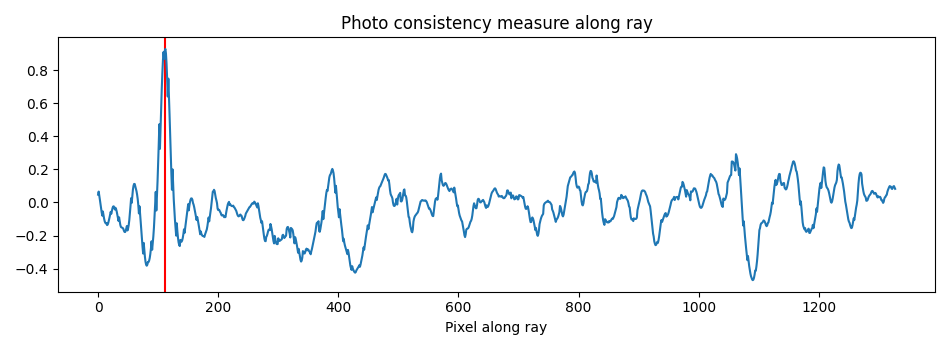

Photo consistency at pixel 112 (support domain shown below):  0.93820687187606


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
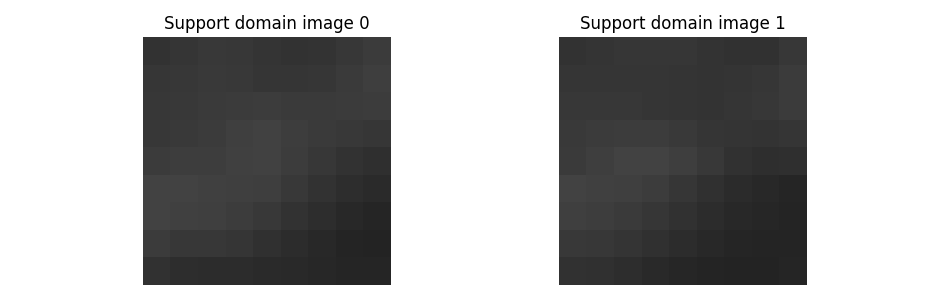

In [8]:
# Asume that pixel0 and pixel1 are inside the image but the support domain might not be
@njit
def photo_consistency_SSD(support0, support1):
    return -np.sum(np.square(support0-support1))

@njit
def photo_consistency_SAD(support0, support1):
    return -np.mean(np.abs(support0-support1))

@njit
def photo_consistency_NCC(support0, support1):

    # this is the implementation like the explanation
    # nom = np.sum( (support0-np.mean(support0)) * (support1-np.mean(support1)) )
    # denom = np.sqrt( np.sum(np.square(support0-np.mean(support0))) * np.sum(np.square(support1-np.mean(support1))) )
    # return np.divide(nom, denom)

    # however, numpy already provides us with a correlation function
    # first we flatten the supports because we don't want covariances 
    # second we are not interested in the whole covariance matrix
    # therefore, select the upper right or lower left element
    return np.corrcoef(support0.flatten(), support1.flatten())[0,1]
    
    
# === VISUALIZATION SETTINGS ===
point3D = points3D_0[123,:]
pc_func = photo_consistency_NCC
support_domain = 16

mvs.plot_photoconsistency_along_ray(image0, image1, camera0, camera1, point3D, pc_func, support_domain)

### Test of exercise 9
The graph in the cell above will show you the response of a photo consistency function along a ray. The pixel with the highest photo consistency value will be matched. The actual matching pixel (for the set of known 3D points) is illustrated with a red vertical line. Try out different photo consistency functions and support domain sizes for different points. The photo consistency will not always be correct but it should be a good estimate in most cases, see the paragraph below.

## Photo consistency accuracy
To get a better idea of how the photo consistency measures perform we can repeat the previous example for each of the known 3D points. The photo consistency measure should peak at the pixel where the 3D point is located in the image. The following code plots the percentile (cumulative percentage) of points whose photo consistency peak lies within a certain distance of the correct pixel. Note that a photo consistency measure is not perfect: not all pixels will match to the correct points.

In [9]:
# Scale image & camera to improve performance
points2D_cam0 = mvs.project_points(camera0, points3D_0)
points2D_cam1 = mvs.project_points(camera1, points3D_0)

# === TEST SETTINGS ===
photo_consistency_func = photo_consistency_SSD
support_domain = 4

errors_in_pixels = []
for pixel0, pixel1 in progressbar.progressbar(list(zip(points2D_cam0.astype(np.int), points2D_cam1.astype(np.int)))):
    height, width = image0.shape
    x, y = pixel0
    if x < support_domain or x >= width - support_domain or y < support_domain or y >= height - support_domain:
        continue    # Walk along the ray and compute the photo consistency at each pixel
    
    pixels, photo_consistency = mvs.compute_photo_consistency_along_ray(
        image0, image1, camera0, camera1, pixel0, photo_consistency_func, support_domain)
    
    if len(pixels) == 0:
        continue
    
    # Compute where along the ray the point should actually be
    pixel1_pos_along_ray = np.argmin(np.sum((pixels - pixel1)**2, axis=1)) # Closest pixel = minimize SSD
    best_pixel_index = np.argmax(photo_consistency)
    errors_in_pixels.append(abs(pixel1_pos_along_ray - best_pixel_index))

print("Number of correct matches (<3): ", np.count_nonzero(np.array(errors_in_pixels) < 3), " out of ", len(errors_in_pixels))

x = np.linspace(0, 100, 100)
y = np.percentile(errors_in_pixels, x)

fig, ax = plt.subplots(figsize=helpers.default_fig_size)
ax.set_title("Distance between highest photo consistency pixel and correct pixel")
ax.plot(x, y)
ax.set_xlabel("Percentile")
ax.set_ylabel("Distance")
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.0f}%'))
plt.show()

C:\Users\GLau\AppData\Local\Temp/ipykernel_9232/2587595671.py:10: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



TypeError: 'module' object is not callable

## Interactive 3D reconstruction
We now have all ingredients to perform 3D reconstruction. We can efficiently iterate over the pixels on the epipolar line and we can find a match among the remaining pixels using a photo consistency measure. Finally, when we have two matching pixels we can compute the 3D point where the rays through those two pixels (almost) intersect.

The following live demo shows everything in action. **Click anywhere in the left image** and the program will automatically compute and draw the photo consistency along the ray (of the pixel you clicked) in the right image. It will also highlight the pixel with the highest photo consistency measure. A ray is shot through the highlighted pixel and a 3D point is computed by intersecting it's ray with the ray through the pixel in the left image.

**NOTE** The set of known 3D points (as described at the start of the notebook) are displayed as black. Points found with this new method are added in red.

In [ ]:
import queue
import threading
import time

# Computes the photo consistency along the epipolar line in image1 of the ray through pixel0 (of camera0).
# The epipolar line is colored using gray scale according the photo consistency measure of each pixel.
#@njit
def draw_epipolar_photo_consistency(image0, image1, camera0, camera1, pixel0, pc_func, support_domain):
    out_image = image1.copy()
    
    pixel1s, photo_consistencies = mvs.compute_photo_consistency_along_ray_color_avg(image0, image1, camera0, camera1, pixel0, pc_func, support_domain)
    min_pc = np.min(photo_consistencies)
    max_pc = np.max(photo_consistencies)
    for (x1, y1), photo_consistency in zip(pixel1s, photo_consistencies):
        photo_consistency = ((photo_consistency - min_pc) / (max_pc - min_pc)) ** 4
        # Draw a slightly thicker (vertically) line
        out_image[y1-1, x1] = photo_consistency
        out_image[y1+0, x1] = photo_consistency
        out_image[y1+1, x1] = photo_consistency
    
    # Return the pixel with the highest photo consistency
    return out_image, tuple(pixel1s[np.argmax(photo_consistencies)])


# Complex 3D plotting stuff = you do not need to understand this
def plot_scatter3D(event_queue):
    fig = go.FigureWidget(layout={"scene": {"aspectmode": "cube"}})
    if flip_axis:
        fig.add_trace(
            go.Scatter3d(
                x=points3D_0[:,1],
                y=points3D_0[:,2],
                z=points3D_0[:,0],
                mode="markers",
                marker=dict(
                    size=3,
                    color="rgb(50,50,50)", # set color to an array/list of desired values
                    colorscale='Viridis', # choose a colorscale
                    opacity=0.5
                )
            )
        )
    else:
        fig.add_trace(
            go.Scatter3d(
                x=points3D_0[:,0],
                y=points3D_0[:,1],
                z=points3D_0[:,2],
                mode="markers",
                marker=dict(
                    size=3,
                    color="rgb(50,50,50)", # set color to an array/list of desired values
                    colorscale='Viridis', # choose a colorscale
                    opacity=0.5
                )
            )
        )
    fig.add_trace(
        go.Scatter3d(
            x=[],
            y=[],
            z=[],
            mode="markers",
            marker=dict(
                size=6,
                color=[], # set color to an array/list of desired values
                colorscale='Viridis', # choose a colorscale
                opacity=0.5
            )
        )
    )
    fig.update_traces()

    def event_handler(event_queue):
        while True:
            point3D, color = event_queue.get() # With timeout so it is possible to interupt the thread
            scatter = fig.data[1]
            x =  list(scatter["x"])
            y =  list(scatter["y"])
            z =  list(scatter["z"])
            colors = list(scatter["marker"]["color"])
            
            if flip_axis:
                x.append(point3D[1])
                y.append(point3D[2])
                z.append(point3D[0])
            else:
                x.append(point3D[0])
                y.append(point3D[1])
                z.append(point3D[2])
                
            r, g, b = color
            colors.append(f"rgb({255*r}, {255*g}, {255*b})")
            
            with fig.batch_update():
                scatter["x"] = x
                scatter["y"] = y
                scatter["z"] = z
                scatter["marker"]["color"] = colors
    
    t = threading.Thread(target=event_handler, args=(event_queue,), daemon=True)
    t.start() # WARNING: thread is not killed when cell is restarted (so this is leaking memory)

    scatter = fig.data[0]
    return fig


def plot_epipolar_line_images2D(event_queue, image0, image1, camera0, camera1, pc_func, support_domain, min_dist, max_dist):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    output_image = image1.copy()
    
    def redraw(pixel0=None, pixel1=None):
        ax1.clear()
        ax2.clear()
        ax1.axis("off")
        ax2.axis("off")
        ax1.imshow(image0)
        ax2.imshow(output_image)
        if pixel0:
            ax1.scatter([pixel0[0]], [pixel0[1]], c="r")
        if pixel1:
            ax2.scatter([pixel1[0]], [pixel1[1]], c="r")
    
    def onclick(event):
        # === User clicked on the image ===
        nonlocal output_image, event_queue
        pixel0 = (int(event.xdata), int(event.ydata))
        
        # Compute the epipolar line and draw it onto image 1
        output_image, pixel1 = draw_epipolar_photo_consistency(image0, image1, camera0, camera1, pixel0, pc_func, support_domain)
        
        # Shoot a ray through the clicked pixel and the matching pixel (with the highest photo consistency)
        ray0 = mvs.pixel_to_ray(camera0, pixel0)
        ray1 = mvs.pixel_to_ray(camera1, pixel1)
        # Find closest point between the two rays
        point3D = closest_point_between_rays(ray0, ray1)
        
        # Ignore matches which are clearly wrong (triangulated point extremely close/far from the camera)
        dist = np.linalg.norm(camera0.pos - point3D)
        if dist < min_dist or dist > max_dist:
            return
        
        #x, y = mvs.project_point(camera0, point3D)
        #color = image0[helpers.round_to_int(y), helpers.round_to_int(x)]
        
        color = (1,0,0) # RED
        event_queue.put((point3D, color))
        redraw(pixel0, pixel1)
    
    # Call draw_epipolar_line (discarding output) so that it is compiled before the user starts clicking.
    print("Compiling...")
    _ = draw_epipolar_photo_consistency(image0, image1, camera0, camera1, (150, 150), pc_func, support_domain)
    print("Done")
    
    redraw()
    
    fig.tight_layout()
    fig.canvas.mpl_connect("button_press_event", onclick)
    #fig.show()
    
def plot_interactive_epipolar_photo_consistency(image0, image1, camera0, camera1, pc_func, support_domain, min_dist, max_dist):
    event_queue = queue.Queue()
    plot_epipolar_line_images2D(event_queue, image0, image1, camera0, camera1, pc_func, support_domain, min_dist, max_dist)
    return plot_scatter3D(event_queue)

fig = plot_interactive_epipolar_photo_consistency(
    image0_color, image1_color,
    camera0, camera1,
    photo_consistency_SSD, 3,
    min_dist, max_dist) # The images do not capture points that are this far away (any triangulated point that is is incorrect)
# TODO: (exercise) click on image and draw epipolar line in the other image. 3D view next to it visualizing the 3D points while they are added
fig

## Complete 3D reconstruction
Clicking on each pixel individually to compute a full 3D reconstruction will take a long time. So the following code will automatically perform the 3D reconstruction process for each pixel in the image. To reduce the potential error, triangulated points that lie very far away are considered false matches and are discarded. Furtermore, pixels for which there are multiple large photo consistency peaks are discarded.

We visualize one out of every 30 found points to prevent your computer from slowing down to much.

**NOTE** If you get a `ZeroDivisionError` then make sure that in `closest_points_on_rays` (exercise 1) you use `np.divide` instead of the `/` symbol (`np.divide` will not throw an exception when a division by 0 is encountered).

In [ ]:
import parallel

@njit
def local_maxima(signal):
    result = []
    for i in range(1, len(signal)-1):
        if signal[i] > signal[i-1] and signal[i] > signal[i+1]:
            result.append(signal[i])
    return result

@njit
def normalize(signal):
    min_signal = np.min(signal)
    return (signal - min_signal) / (np.max(signal) - min_signal)

def compute_point_cloud(image0, image1, camera0, camera1, pc_func, support_domain, min_dist, max_dist):
    assert(image0.shape == image1.shape)
    height, width = image0.shape[:2]
       
    @njit
    def kernel(x, y):
        if x < support_domain or x >= width - support_domain or y < support_domain or y >= height - support_domain:
            return None
        
        pixel0 = (x, y)
        pixel1s, photo_consistencies = mvs.compute_photo_consistency_along_ray_color_avg(image0, image1, camera0, camera1, pixel0, pc_func, support_domain)
        if len(photo_consistencies) == 0:
            return None
        
        # Discard if there are multiple large peaks in the photo consistency.
        normalized_photo_consistencies = normalize(photo_consistencies)
        photo_consistency_peaks = local_maxima(normalized_photo_consistencies)
        # https://stackoverflow.com/questions/33181350/quickest-way-to-find-the-nth-largest-value-in-a-numpy-matrix
        second_largest_photo_consistency_peak = np.partition(photo_consistency_peaks, -2)[-2]
        # Max peak = 1.0 (normalized) so if the second highest peak is higher than 0.975 the max peak then discard
        if second_largest_photo_consistency_peak > 0.975:
            return None
        
        pixel1 = pixel1s[np.argmax(photo_consistencies)]
        ray0 = mvs.pixel_to_ray(camera0, pixel0)
        ray1 = mvs.pixel_to_ray(camera1, pixel1)
        point3D = closest_point_between_rays(ray0, ray1)

        # Discard points that lie behind the cameras
        if np.dot(point3D - camera0.pos, ray0[1]) < 0 or np.dot(point3D - camera1.pos, ray1[1]) < 0:
            return None
        
        # Discard obviously wrong rays (behind the camera or very far away)
        dist = np.linalg.norm(point3D - camera0.pos)
        if dist < min_dist or dist > max_dist:
            return None

        return (point3D, image0[y, x])
        
    points3D = parallel.transform_reduce_2D_to_1D(kernel, width, height)
    return (np.array([p for p, c in points3D], np.float32), np.array([c for p, c in points3D], np.float32))
    
import os
if not os.environ.get("NBGRADER_VALIDATING"): # Skip this code when grading
    points3D, colors3D = compute_point_cloud(image1_color_quarter_res, image0_color_quarter_res, camera1_quarter_res, camera0_quarter_res,
                                         photo_consistency_SSD, 3, min_dist, max_dist)

    print(f"Num points: {len(points3D)}")
    np.random.shuffle(points3D)
    trace = plotly_points(points3D[::20,:], color=colors3D) # Only show one in every twenty points to improve performance
    go.Figure(data=[trace], layout={"scene": {"aspectmode": "cube"}}).show()